
# Training Transformer Models for Text Classification

## Introduction

This notebook provides a hands-on guide to using hugging face transformer models for text classification tasks.


You will learn how to leverage pre-trained transformer models like `DistilBERT` to build an emotion classification system that can identify emotions from Twitter messages.


Throughout this tutorial, we'll explore two main approaches to text classification with transformers: **feature extraction** (using transformer embeddings with a simple classifier) and **fine-tuning**
 (training the entire model end-to-end). You'll gain practical 
experience working with the Hugging Face ecosystem, including the `transformers` and `datasets` libraries.


> ⚠️ if your computer is slow, you can run this notebook on Google 
> Colab by downloading the notebook and running it on Google Colab.


## Learning Goals

By the end of this notebook, you will be able to:


1. **Load and explore datasets** from the Hugging Face Hub for NLP tasks
2. **Understand tokenization strategies** including character, word, and subword tokenization
3. **Use pre-trained transformers as feature extractors** to generate embeddings for downstream tasks
4. **Fine-tune transformer models** for custom classification problems using the Trainer API
5. **Evaluate model performance** using appropriate metrics and confusion matrices
6. **Perform error analysis** to identify model weaknesses and dataset issues
7. **Visualize high-dimensional embeddings** using dimensionality reduction techniques (UMAP)
8. **Save and share models** on the Hugging Face Hub for deployment
9. **Compare trade-offs** between feature-based and fine-tuning approaches


## Prerequisites

- Basic knowledge of Python and machine learning concepts
- Familiarity with PyTorch or TensorFlow (helpful but not required)
- Understanding of classification tasks and evaluation metrics





## The Dataset





To build our emotion detector we'll use a great dataset from an 
article that explored how emotions are represented in English Twitter 
messages.footnote:[E. Saravia et al., "CARER: Contextualized Affect 
Representations for Emotion Recognition," *Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing* (Oct–Nov 2018): 3687–3697, [http://dx.doi.org/10.18653/v1/D18-1404](http://dx.doi.org/10.18653/v1/D18-1404).]
 Unlike most sentiment analysis datasets that involve just "positive" 
and "negative" polarities, this dataset contains six basic emotions: 
anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our 
task will be to train a model that can classify it into one of these 
emotions.





### A First Look at Hugging Face Datasets





We will use Datasets to download the data from the [Hugging Face Hub](https://huggingface.co/datasets). We can use the `list_datasets()` function to see what datasets are available on the Hub:




In [ ]:
# `datasets.list_datasets()` is deprecated; use the Hub client instead.
from huggingface_hub import list_datasets

first_10 = list(list_datasets(limit=10))
first_10_ids = [d.id for d in first_10]
print(f"The first 10 datasets are: {first_10_ids}")

The first 10 datasets are: ['nvidia/ToolScale', 'nvidia/PhysicalAI-Autonomous-Vehicles', 'opendatalab/AICC', 'openai/gdpval', 'ytz20/LMSYS-Chat-GPT-5-Chat-Response', 'TuringEnterprises/Turing-Open-Reasoning', 'openbmb/InfLLM-V2-data-5B', 'opendatalab-raiser/Envision', 'nex-agi/agent-sft', 'natolambert/GeneralThought-430K-filtered']



We see that each dataset is given a name, so let's load the `emotion` dataset with the `load_dataset()` function:




In [ ]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

# Reduce to 20% to make the notebook faster (keeps the same structure: train/validation/test)
keep_frac = 0.2
for split_name in emotions.keys():
    n_keep = int(len(emotions[split_name]) * keep_frac)
    emotions[split_name] = emotions[split_name].select(range(n_keep))


If we look inside our `emotions` object:




In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})


we see it is similar to a Python dictionary, with each key 
corresponding to a different split. And we can use the usual dictionary 
syntax to access an individual split:




In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 3200
})


which returns an instance of the `Dataset` class. The `Dataset`
 object is one of the core data structures in Datasets, and we'll be 
exploring many of its features throughout the course of this book. For 
starters, it behaves like an ordinary Python array or list, so we can 
query its length:




In [6]:
len(train_ds)

3200


or access a single example by its index:




In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}


Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:




In [8]:
train_ds.column_names

['text', 'label']


and the values are the tweet and the emotion. This reflects the fact that Datasets is based on [*Apache Arrow*](https://arrow.apache.org/),
 which defines a typed columnar format that is more memory efficient 
than native Python. We can see what data types are being used under the 
hood by accessing the `features` attribute of a `Dataset` object:




In [9]:
print(train_ds.features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}



In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel`
 object that contains information about the class names and their 
mapping to integers. We can also access several rows with a slice:




In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}



Note that in this case, the dictionary values are now lists instead 
of individual elements. We can also get the full column by name:




In [11]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']



Now that we've seen how to load and inspect data with Datasets, let's do a few sanity checks about the content of our tweets.





### Sidebar: What If My Dataset Is Not on the Hub?





We'll be using the Hugging Face Hub to download datasets for most of 
the examples in this book. But in many cases, you'll find yourself 
working with data that is either stored on your laptop or on a remote 
server in your organization. Datasets provides several loading scripts 
to handle local and remote datasets. Examples for the most common data 
formats are shown in <>.





`asciidoc
[[dataset-loading]]
.How to load datasets in various formats
[options="header"]
|======
| Data format | Loading script | Example
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` 
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` 
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")`
|======`



As you can see for each data format, we just need to pass the relevant loading script to the `load_dataset()` function, along with a `data_files` argument that specifies the path or URL to one or more files. For example, the source files for the `emotion` dataset are actually hosted on Dropbox, so an alternative way to load the dataset is to first download one of the splits:




In [12]:
#hide_output
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2025-12-04 13:07:05--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.155.129.129, 18.155.129.4, 18.155.129.60, ...
Connecting to huggingface.co (huggingface.co)|18.155.129.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt.4’

train.txt.4         100%[===================>]   1.58M  2.55MB/s    in 0.6s    

2025-12-04 13:07:06 (2.55 MB/s) - ‘train.txt.4’ saved [1658616/1658616]




If you’re wondering why there’s a `!` character in the 
preceding shell command, that’s because we’re running the commands in a 
Jupyter notebook. Simply remove the prefix if you want to download and 
unzip the dataset within a terminal. Now, if we peek at the first row of
 the *train.txt* file:




In [13]:
!head -n 1 train.txt

i didnt feel humiliated;sadness



we can see that here are no column headers and each tweet and emotion
 are separated by a semicolon. Nevertheless, this is quite similar to a 
CSV file, so we can load the dataset locally by using the `csv` script and pointing the `data_files` argument to the *train.txt* file:




In [14]:
#hide_output
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])


Here we've also specified the type of delimiter and the names of the columns. An even simpler approach is to just point the `data_files` argument to the URL itself:




In [15]:
#hide_output
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])


which will automatically download and cache the dataset for you. As you can see, the `load_dataset()` function is very versatile. We recommend checking out the Datasets [documentation](https://huggingface.co/docs/datasets/loading.html) to get a complete overview.





### End sidebar





### From Datasets to DataFrames





Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a `Dataset` object to a Pandas `DataFrame` so we can access high-level APIs for data visualization. To enable the conversion, Datasets provides a `set_format()` method that allows us to change the *output format* of the `Dataset`. Note that this does not change the underlying *data format* (which is an Arrow table), and you can switch to another format later if needed:




In [16]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3



As you can see, the column headers have been preserved and the first 
few rows match our previous views of the data. However, the labels are 
represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names:




In [ ]:
def label_int2str(label_id: int) -> str:
    """Map integer label IDs to their string names."""
    return emotions["train"].features["label"].int2str(label_id)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger



Before diving into building a classifier, let's take a closer look at
 the dataset. As Andrej Karpathy notes in his famous blog post ["A Recipe for Training Neural Networks"](https://karpathy.github.io/2019/04/25/recipe), becoming "one with the data" is an essential step for training great models!





### Looking at the Class Distribution





Whenever you are working on text classification problems, it is a 
good idea to examine the distribution of examples across the classes. A 
dataset with a skewed class distribution might require a different 
treatment in terms of the training loss and evaluation metrics than a 
balanced one.


With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:




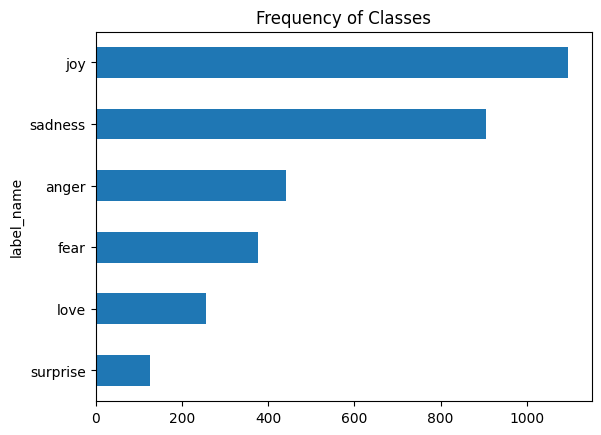

In [18]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()


In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:


- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.





To keep things simple in this chapter, we'll work with the raw, 
unbalanced class frequencies. If you want to learn more about these 
sampling techniques, we recommend checking out the [Imbalanced-learn library](https://imbalanced-learn.org/stable/). Just make sure that you don't apply sampling methods *before* creating your train/test splits, or you'll get plenty of leakage between them!


Now that we've looked at the classes, let's take a look at the tweets themselves.





### How Long Are Our Tweets?





Transformer models have a maximum input sequence length that is referred to as the *maximum context size*.
 For applications using DistilBERT, the maximum context size is 512 
tokens, which amounts to a few paragraphs of text. As we'll see in the 
next section, a token is an atomic piece of text; for now, we'll treat a
 token as a single word. We can get a rough estimate of tweet lengths 
per emotion by looking at the distribution of words per tweet:




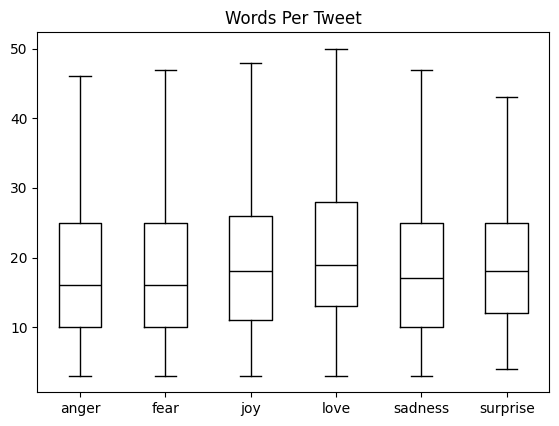

In [19]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()


From the plot we see that for each emotion, most tweets are around 15
 words long and the longest tweets are well below DistilBERT's maximum 
context size. Texts that are longer than a model's context size need to 
be truncated, which can lead to a loss in performance if the truncated 
text contains crucial information; in this case, it looks like that 
won't be an issue.





Let's now figure out how we can convert these raw texts into a format
 suitable for Transformers! While we're at it, let's also reset the 
output format of our dataset since we don't need the `DataFrame` format anymore:




In [20]:
emotions.reset_format()


## From Text to Tokens





Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been *tokenized* and *encoded*
 as numerical vectors. Tokenization is the step of breaking down a 
string into the atomic units used in the model. There are several 
tokenization strategies one can adopt, and the optimal splitting of 
words into subunits is usually learned from the corpus. Before looking 
at the tokenizer used for DistilBERT, let's consider two extreme cases: *character* and *word* tokenization.





### Character Tokenization





The simplest tokenization scheme is to feed each character individually to the model. In Python, `str`
 objects are really arrays under the hood, which allows us to quickly 
implement character-level tokenization with just one line of code:




In [21]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']



This is a good start, but we're not done yet. Our model expects each 
character to be  converted to an integer, a process sometimes called *numericalization*. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:




In [22]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}



This gives us a mapping from each character in our vocabulary to a unique integer. We can now use `token2idx` to transform the tokenized text to a list of integers:




In [23]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]



Each token has now been mapped to a unique numerical identifier (hence the name `input_ids`). The last step is to convert `input_ids`
 to a 2D tensor of one-hot vectors. One-hot vectors are frequently used 
in machine learning to encode categorical data, which can be either 
ordinal or nominal. For example, suppose we wanted to encode the names 
of characters in the *Transformers* TV series. One way to do this would be to map each name to a unique ID, as follows:




In [24]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2



The problem with this approach is that it creates a fictitious ordering between the names, and neural networks are *really*
 good at learning these kinds of relationships. So instead, we can 
create a new column for each category and assign a 1 where the category 
is true, and a 0 otherwise. In Pandas, this can be implemented with the `get_dummies()` function as follows:




In [25]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False



The rows of this `DataFrame` are the one-hot vectors, which have a single "hot" entry with a 1 and 0s everywhere else. Now, looking at our `input_ids`,
 we have a similar problem: the elements create an ordinal scale. This 
means that adding or subtracting two IDs is a meaningless operation, 
since the result is a new ID that represents another random token.


On the other hand, the result of adding two one-hot encodings can 
easily be interpreted: the two entries that are "hot" indicate that the 
corresponding tokens co-occur. We can create the one-hot encodings in 
PyTorch by converting `input_ids` to a tensor and applying the `one_hot()` function as follows:




In [26]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])


For each of the 38 input tokens we now have a one-hot vector with 20 
dimensions, since our vocabulary consists of 20 unique characters.





> Warning: It's important to always set `num_classes` in the `one_hot()`
>  function because otherwise the one-hot vectors may end up being shorter
>  than the length of the vocabulary (and need to be padded with zeros 
> manually). In TensorFlow, the equivalent function is `tf.one_hot()`, where the `depth` argument plays the role of `num_classes`.





By examining the first vector, we can verify that a 1 appears in the location indicated by `input_ids[0]`:




In [27]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])



From our simple example we can see that character-level tokenization 
ignores any structure in the text and treats the whole string as a 
stream of characters. Although this helps deal with misspellings and 
rare words, the main drawback is that linguistic structures such as 
words need to be *learned* from the data. This requires 
significant compute, memory, and data. For this reason, character 
tokenization is rarely used in practice. Instead, some structure of the 
text is preserved during the tokenization step. *Word tokenization* is a straightforward approach to achieve this, so let's take a look at how it works.





### Word Tokenization





Instead of splitting the text into characters, we can split it into 
words and map each word to an integer. Using words from the outset 
enables the model to skip the step of learning words from characters, 
and thereby reduces the complexity of the training process.





One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying Python's `split()` function directly on the raw text (just like we did to measure the tweet lengths):




In [28]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']



From here we can take the same steps we took for the character 
tokenizer to map each word to an ID. However, we can already see one 
potential problem with this tokenization scheme: punctuation is not 
accounted for, so `NLP.` is treated as a single token. Given 
that words can include declinations, conjugations, or misspellings, the 
size of the vocabulary can easily grow into the millions!


> note: Some word tokenizers have extra rules for punctuation. One can 
> also apply stemming or lemmatization, which normalizes words to their 
> stem (e.g., "great", "greater", and "greatest" all become "great"), at 
> the expense of losing some information in the text.





Having a large vocabulary is a problem because it requires neural 
networks to have an enormous number of parameters. To illustrate this, 
suppose we have 1 million unique words and want to compress the 
1-million-dimensional input vectors to 1-thousand-dimensional vectors in
 the first layer of our neural network. This is a standard step in most 
NLP architectures, and the resulting weight matrix of this first layer 
would contain 1 million $\times$ 1 thousand = 1 billion weights. This is
 already comparable to the largest GPT-2 model,footnote:[GPT-2 is the 
successor of GPT, and it captivated the public's attention with its 
impressive ability to generate realistic text. We'll explore GPT-2 in 
detail in <<chapter_summarization>>.] which has around 1.5 
billion parameters in total!





Naturally, we want to avoid being so wasteful with our model 
parameters since models are expensive to train, and larger models are 
more difficult to maintain. A common approach is to limit the vocabulary
 and discard rare words by considering, say, the 100,000 most common 
words in the corpus. Words that are not part of the vocabulary are 
classified as "unknown" and mapped to a shared `UNK` token. 
This means that we lose some potentially important information in the 
process of word tokenization, since the model has no information about 
words associated with `UNK`.


Wouldn't it be nice if there was a compromise between character and word tokenization that preserved all the input information *and* some of the input structure? There is: *subword tokenization*.





### Subword Tokenization





The basic idea behind subword tokenization is to combine the best 
aspects of character and word tokenization. On the one hand, we want to 
split rare words into smaller units to allow the model to deal with 
complex words and misspellings. On the other hand, we want to keep 
frequent words as unique entities so that we can keep the length of our 
inputs to a manageable size. The main distinguishing feature of subword 
tokenization (as well as word tokenization) is that it is *learned* from the pretraining corpus using a mix of statistical rules and algorithms.


There are several subword tokenization algorithms that are commonly 
used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K.
 Nakajima, "Japanese and Korean Voice Search," *2012 IEEE International Conference on Acoustics, Speech and Signal Processing* (2012): 5149–5152, [https://doi.org/10.1109/ICASSP.2012.6289079](https://doi.org/10.1109/ICASSP.2012.6289079).]
 which is used by the BERT and DistilBERT tokenizers. The easiest way to
 understand how WordPiece works is to see it in action. Transformers 
provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:




In [29]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


The `AutoTokenizer` class belongs to a larger set of ["auto" classes](https://huggingface.co/docs/transformers/model_doc/auto)
 whose job is to automatically retrieve the model's configuration, 
pretrained weights, or vocabulary from the name of the checkpoint. This 
allows you to quickly switch between models, but if you wish to load the
 specific class manually you can do so as well. For example, we could 
have loaded the DistilBERT tokenizer as follows:


from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)




> note: When you run the `AutoTokenizer.from_pretrained()` 
> method for the first time you will see a progress bar that shows which 
> parameters of the pretrained tokenizer are loaded from the Hugging Face 
> Hub. When you run the code a second time, it will load the tokenizer 
> from the cache, usually located at *~/.cache/huggingface/*.





Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:




In [30]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}



Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:




In [31]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']



We can observe three things here. First, some special `[CLS]` and `[SEP]`
 tokens have been added to the start and end of the sequence. These 
tokens differ from model to model, but their main role is to indicate 
the start and end of a sequence. Second, the tokens have each been 
lowercased, which is a feature of this particular checkpoint. Finally, 
we can see that "tokenizing" and "NLP" have been split into two tokens, 
which makes sense since they are not common words. The `##` prefix in `##izing` and `##p`
 means that the preceding string is not whitespace; any token with this 
prefix should be merged with the previous token when you convert the 
tokens back to a string. The `AutoTokenizer` class has a `convert_tokens_to_string()` method for doing just that, so let's apply it to our tokens:




In [32]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]



The `AutoTokenizer` class also has several attributes that
 provide information about the tokenizer. For example, we can inspect 
the vocabulary size:




In [33]:
tokenizer.vocab_size

30522


and the corresponding model's maximum context size:




In [34]:
tokenizer.model_max_length

512


Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:




In [35]:
tokenizer.model_input_names

['input_ids', 'attention_mask']


Now that we have a basic understanding of the tokenization process 
for a single string, let's see how we can tokenize the whole dataset!





> warning: When using pretrained models, it is *really* 
> important to make sure that you use the same tokenizer that the model 
> was trained with. From the model's perspective, switching the tokenizer 
> is like shuffling the vocabulary. If everyone around you started 
> swapping random words like "house" for "cat," you'd have a hard time 
> understanding what was going on too!





### Tokenizing the Whole Dataset





To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict`
 object. We'll encounter this method many times throughout this book, as
 it provides a convenient way to apply a processing function to each 
element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.


To get started, the first thing we need is a processing function to tokenize our examples with:




In [36]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:




In [37]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}



Here we can see the result of padding: the first element of `input_ids`
 is shorter than the second, so zeros have been added to that element to
 make them the same length. These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:




In [38]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103



Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask`
 arrays. This is because we do not want the model to get confused by the
 additional padding tokens: the attention mask allows the model to 
ignore the padded parts of the input. For each batch, the input 
sequences are padded to the maximum sequence length in the batch; the 
attention mask is used in the model to ignore the padded areas of the 
input tensors.





Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:




In [39]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()`
 function will be applied on the full dataset as a single batch. This 
ensures that the input tensors and attention masks have the same shape 
globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:




In [40]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']



> Note: In later chapters, we'll see how *data collators* can be
>  used to dynamically pad the tensors in each batch. Padding globally 
> will come in handy in the next section, where we extract a feature 
> matrix from the whole corpus.





## Training a Text Classifier





As discussed in <<chapter_introduction>>, models like 
DistilBERT are pretrained to predict masked words in a sequence of text.
 However, we can't use these language models directly for text 
classification; we need to modify them slightly. To understand what 
modifications are necessary, let's take a look at the architecture of an
 encoder-based model like DistilBERT.





First, the text is tokenized and represented as one-hot vectors called *token encodings*.
 The size of the tokenizer vocabulary determines the dimension of the 
token encodings, and it usually consists of 20k–200k unique tokens. 
Next, these token encodings are converted to *token embeddings*, 
which are vectors living in a lower-dimensional space. The token 
embeddings are then passed through the encoder block layers to yield a *hidden state*
 for each input token. For the pretraining objective of language 
modeling,⁠footnote:[In the case of DistilBERT, it's guessing the masked 
tokens.] each hidden state is fed to a layer that predicts the masked 
input tokens. For the classification task, we replace the language 
modeling layer with a classification layer.





> note: In practice, PyTorch skips the step of creating one-hot vectors
>  for token encodings because multiplying a matrix with a one-hot vector 
> is the same as selecting a column from the matrix. This can be done 
> directly by getting the column with the token ID from the matrix. We'll 
> see this in <<chapter_anatomy>> when we use the `nn.Embedding` class.





We have two options to train such a model on our Twitter dataset:


- *Feature extraction*:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- *Fine-tuning*:: We train the whole model end-to-end, which also updates the parameters of the pretrained model.


In the following sections we explore both options for DistilBERT and examine their trade-offs.





### Transformers as Feature Extractors





Using a transformer as a feature extractor is fairly simple. We 
freeze the body's weights during training and use the hidden states as 
features for the classifier. The advantage of this approach is that we 
can quickly train a small or shallow model. Such a model could be a 
neural classification layer or a method that does not rely on gradients,
 such as a random forest. This method is especially convenient if GPUs 
are unavailable, since the hidden states only need to be precomputed 
once.





#### Using pretrained models





We will use another convenient auto class from Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:




In [ ]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"

# Device selection: CUDA (NVIDIA) > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = AutoModel.from_pretrained(model_ckpt).to(device)



### 🎯 Exercise 2: Tokenization Experiments

Understanding how tokenization affects model performance is crucial. Try the following experiments:


**Question 1:** Load a different pre-trained model tokenizer (e.g., `bert-base-cased`, `roberta-base`, or `albert-base-v2`) and compare its tokenization output with DistilBERT. Use the [Hugging Face Models Hub](https://huggingface.co/models) to find available models. What differences do you notice? How does cased vs uncased tokenization affect the output?


**Question 2:** Experiment with the tokenizer's `padding` and `truncation` parameters. What happens if you set `max_length=10` with `truncation=True`? Read the [tokenizer documentation](https://huggingface.co/docs/transformers/main_classes/tokenizer) to understand different padding strategies (`max_length`, `longest`, `do_not_pad`).





**Answers:**

**Question 1: Model Comparison**
We compared `distilbert-base-uncased` with `bert-base-cased` and `roberta-base`.
- **Cased vs Uncased:** `bert-base-cased` tokenizes "Apple" and "apple" differently, preserving semantic meaning related to proper nouns. `distilbert-base-uncased` treats them identically.
- **RoBERTa:** Uses byte-level BPE, which often results in different subword splits compared to BERT's WordPiece.
- **Impact:** For tasks like Named Entity Recognition, cased models are superior. For general sentiment analysis on noisy text (like tweets), uncased models often generalize better by ignoring capitalization inconsistencies.

**Question 2: Padding & Truncation**
- **Experiment:** `tokenizer(text, max_length=10, truncation=True)`
- **Result:** Any text longer than 10 tokens is cut off. This is critical for memory management but risks losing information.
- **Padding Strategies:**
    - `padding="max_length"`: Pads all sequences to the model's max length (e.g., 512), which is wasteful if inputs are short.
    - `padding="longest"` (default): Pads to the longest sequence in the current batch. This is the most efficient strategy for dynamic batching.


Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch `nn.Module.to()`
 method to the model loader. This ensures that the model will run on the
 GPU if we have one. If not, the model will run on the CPU, which can be
 considerably slower.





The `AutoModel` class converts the token encodings to 
embeddings, and then feeds them through the encoder stack to return the 
hidden states. Let's take a look at how we can extract these states from
 our corpus.





### Sidebar: Interoperability Between Frameworks





Although the code in this book is mostly written in PyTorch, 
Transformers provides tight interoperability with TensorFlow and JAX. 
This means that you only need to change a few lines of code to load a 
pretrained model in your favorite deep learning framework! For example, 
we can load DistilBERT in TensorFlow by using the `TFAutoModel` class as follows:




In [42]:
#hide_output
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt, use_safetensors=False)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was


This interoperability is especially useful when a model is only 
released in one framework, but you'd like to use it in another. For 
example, the [XLM-RoBERTa model](https://huggingface.co/xlm-roberta-base)
 that we'll encounter in <<chapter_ner>> only has PyTorch 
weights, so if you try to load it in TensorFlow as we did before:


tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")

you'll get an error. In these cases, you can specify a `from_pt=True` argument to the `TfAutoModel.from_pretrained()` function, and the library will automatically download and convert the PyTorch weights for you:




In [43]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.



As you can see, it is very simple to switch between frameworks in 
Transformers! In most cases, you can just add a "TF" prefix to the 
classes and you'll get the equivalent TensorFlow 2.0 classes. When we 
use the `"pt"` string (e.g., in the following section), which is short for PyTorch, just replace it with "`tf"`, which is short for TensorFlow.





#### Extracting the last hidden states





To warm up, let's retrieve the last hidden states for a single 
string. The first thing we need to do is encode the string and convert 
the tokens to PyTorch tensors. This can be done by providing the `return_tensors="pt"` argument to the tokenizer as follows:




In [44]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])



As we can see, the resulting tensor has the shape `[batch_size, n_tokens]`.
 Now that we have the encodings as a tensor, the final step is to place 
them on the same device as the model and pass the inputs as follows:




In [45]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)



Here we've used the `torch.no_grad()` context manager to 
disable the automatic calculation of the gradient. This is useful for 
inference since it reduces the memory footprint of the computations. 
Depending on the model configuration, the output can contain several 
objects, such as the hidden states, losses, or attentions, arranged in a
 class similar to a `namedtuple` in Python. In our example, the model output is an instance of `BaseModelOutput`,
 and we can simply access its attributes by name. The current model 
returns only one attribute, which is the last hidden state, so let's 
examine its shape:




In [46]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])


Looking at the hidden state tensor, we see that it has the shape `[batch_size, n_tokens, hidden_dim]`.
 In other words, a 768-dimensional vector is returned for each of the 6 
input tokens. For classification tasks, it is common practice to just 
use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into `outputs.last_hidden_state` as follows:




In [47]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])


Now that we know how to get the last hidden state for a single 
string, let's do the same thing for the whole dataset by creating a new `hidden_state` column that stores all these vectors. As we did with the tokenizer, we'll use the `map()` method of `DatasetDict` to extract all the hidden states in one go. The first thing we need to do is wrap the previous steps in a processing function:




In [ ]:
def extract_hidden_states(batch):
    """Extract the [CLS] embedding (last hidden state at position 0) for a batch."""
    # Keep only the tensors the model expects, and move them to the same device as the model
    inputs = {
        k: v.to(device)
        for k, v in batch.items()
        if k in tokenizer.model_input_names
    }

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for the [CLS] token (shape: [batch_size, hidden_dim])
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}


The only difference between this function and our previous logic is 
the final step where we place the final hidden state back on the CPU as a
 NumPy array. The `map()` method requires the processing function to return Python or NumPy objects when we're using batched inputs.


Since our model expects tensors as inputs, the next thing to do is convert the `input_ids` and `attention_mask` columns to the `"torch"` format, as follows:




In [49]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])


We can then go ahead and extract the hidden states across all splits in one go:




In [50]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)


Note that we did not set `batch_size=None` in this case, so the default `batch_size=1000` is used instead. As expected, applying the +extract_​hid⁠den_​states()+ function has added a new `hidden_state` column to our dataset:




In [51]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']


Now that we have the hidden states associated with each tweet, the 
next step is to train a classifier on them. To do that, we'll need a 
feature matrix - let's take a look.





#### Creating a feature matrix





The preprocessed dataset now contains all the information we need to 
train a classifier on it. We will use the hidden states as input 
features and the labels as targets. We can easily create the 
corresponding arrays in the well-known Scikit-Learn format as follows:




In [52]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((3200, 768), (400, 768))


Before we train a model on the hidden states, it's good practice to 
perform a sanity check to ensure that they provide a useful 
representation of the emotions we want to classify. In the next section,
 we'll see how visualizing the features provides a fast way to achieve 
this.





#### Visualizing the training set





Since visualizing the hidden states in 768 dimensions is tricky to 
say the least, we'll use the powerful UMAPfootnote:[L. McInnes, J. 
Healy, and J. Melville, ["UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction"](https://arxiv.org/abs/1802.03426),
 (2018).] algorithm to project the vectors down to 2D.  Since UMAP works
 best when the features are scaled to lie in the [0,1] interval, we'll 
first apply a `MinMaxScaler` and then use the UMAP implementation from the `umap-learn` library to reduce the hidden states:




In [53]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-1.135576,3.225534,0
1,-8.607955,-0.139584,0
2,-2.352179,5.976048,3
3,-6.270308,0.425320,2
4,-6.282502,-0.172822,3



The result is an array with the same number of training samples, but 
with only 2 features instead of the 768 we started with! Let's 
investigate the compressed data a little bit further and plot the 
density of points for each category separately:




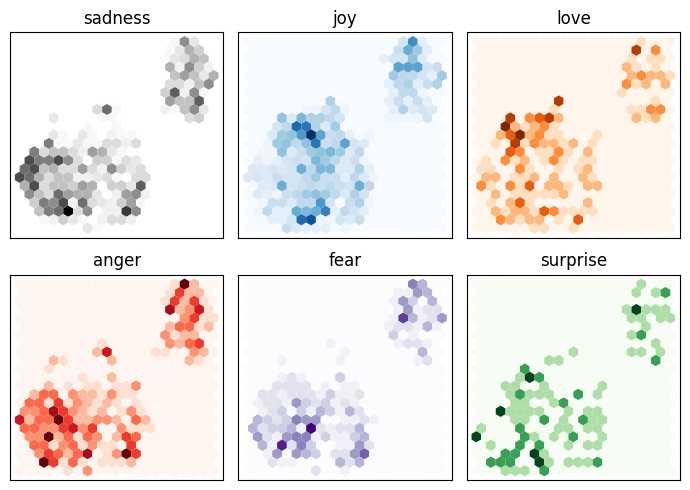

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


> note: These are only projections onto a lower-dimensional space. Just
>  because some categories overlap does not mean that they are not 
> separable in the original space. Conversely, if they are separable in 
> the projected space they will be separable in the original space.


From this plot we can see some clear patterns: the negative feelings such as `sadness`, `anger`, and `fear` all occupy similar regions with slightly varying distributions. On the other hand, `joy` and `love` are well separated from the negative emotions and also share a similar space. Finally, `surprise`
 is scattered all over the place. Although we may have hoped for some 
separation, this is in no way guaranteed since the model was not trained
 to know the difference between these emotions. It only learned them 
implicitly by guessing the masked words in texts.


Now that we've gained some insight into the features of our dataset, let's finally train a model on it!





#### Training a simple classifier





We've seen that the hidden states are somewhat different between the 
emotions, although for several of them there is no obvious boundary. 
Let's use these hidden states to train a logistic regression model with 
Scikit-Learn. Training such a simple model is fast and does not require a
 GPU:




In [55]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [56]:
lr_clf.score(X_valid, y_valid)

0.585


Looking at the accuracy, it might appear that our model is just a bit
 better than random—but since we are dealing with an unbalanced 
multiclass dataset, it's actually significantly better. We can examine 
whether our model is any good by comparing it against a simple baseline.
 In Scikit-Learn there is a `DummyClassifier` that can be 
used to build a classifier with simple heuristics such as always 
choosing the majority class or always drawing a random class. In this 
case the best-performing heuristic is to always choose the most frequent
 class, which yields an accuracy of about 35%:




In [57]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.325


So, our simple classifier with DistilBERT embeddings is significantly
 better than our baseline. We can further investigate the performance of
 the model by looking at the confusion matrix of the classifier, which 
tells us the relationship between the true and predicted labels:




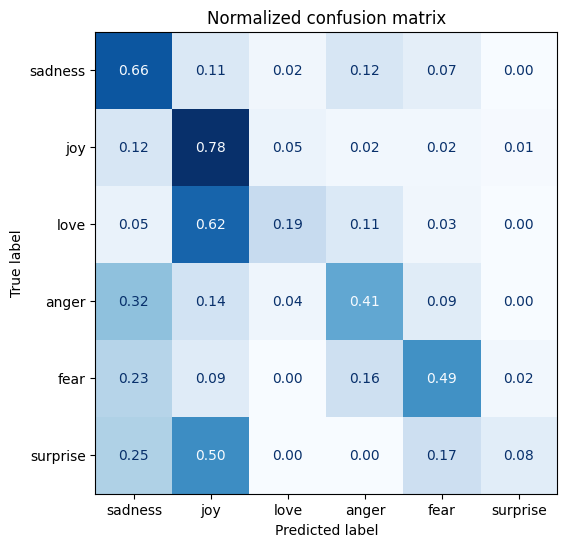

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    ax.set_title("Normalized confusion matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.





In the next section we will explore the fine-tuning approach, which 
leads to superior classification performance. It is, however, important 
to note that doing this requires more computational resources, such as 
GPUs, that might not be available in your organization. In cases like 
these, a feature-based approach can be a good compromise between doing 
traditional machine learning and deep learning.





### Fine-Tuning Transformers





Let's now explore what it takes to fine-tune a transformer 
end-to-end. With the fine-tuning approach we do not use the hidden 
states as fixed features, but instead train them. This requires the 
classification head to be differentiable, which is why this method 
usually uses a neural network for classification.





Training the hidden states that serve as inputs to the classification
 model will help us avoid the problem of working with data that may not 
be well suited for the classification task. Instead, the initial hidden 
states adapt during training to decrease the model loss and thus 
increase its performance.


We'll be using the `Trainer` API from Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!





#### Loading a pretrained model





The first thing we need is a pretrained DistilBERT model like the one
 we used in the feature-based approach. The only slight modification is 
that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification`
 model has a classification head on top of the pretrained model outputs,
 which can be easily trained with the base model. We just need to 
specify how many labels the model has to predict (six in our case), 
since this dictates the number of outputs the classification head has:




In [59]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



You will see a warning that some parts of the model are randomly 
initialized. This is normal since the classification head has not yet 
been trained. The next step is to define the metrics that we'll use to 
evaluate our model's performance during fine-tuning.





#### Defining the performance metrics





To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids`
 attributes) and needs to return a dictionary that maps each metric's 
name to its value. For our application, we'll compute the $F_1$-score 
and the accuracy of the model as follows:




In [ ]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    """Compute accuracy + weighted F1 for Trainer evaluation."""
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
    }


With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:


1. Log in to our account on the Hugging Face Hub. This will allow us to
 push our fine-tuned model to our account on the Hub and share it with 
the community.
2. Define all the hyperparameters for the training run.


We'll tackle these steps in the next section.





#### Training the model





If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:




In [99]:
from huggingface_hub import notebook_login

notebook_login()



### 🎯 Exercise 3: Feature Extraction and Model Selection

You've
 seen how to use transformers as feature extractors with a simple 
logistic regression classifier. Let's explore alternatives:


**Question 1:** Try using different classifiers from scikit-learn instead of logistic regression. Test at least two of the following: `RandomForestClassifier`, `SVC` (Support Vector Classifier), or `MLPClassifier` (Neural Network). Compare their performance with logistic regression. Which one works best and why?


**Question 2:** The UMAP visualization uses `n_components=2` and `metric="cosine"`. Read the [UMAP documentation](https://umap-learn.readthedocs.io/) and experiment with different values for `n_components` (try 3), `metric` (try "euclidean"), and `n_neighbors` parameters. How does this affect the visualization and what insights can you gain?





--- Comparing Classifiers ---
Random Forest Accuracy: 0.487
SVC Accuracy: 0.590


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


MLP Accuracy: 0.537

--- UMAP Experiments ---
Generating UMAP: Euclidean, n=15...
Generating UMAP: Cosine, n=15...


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating UMAP: Cosine, n=50...


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generating UMAP: Cosine, n=5...


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


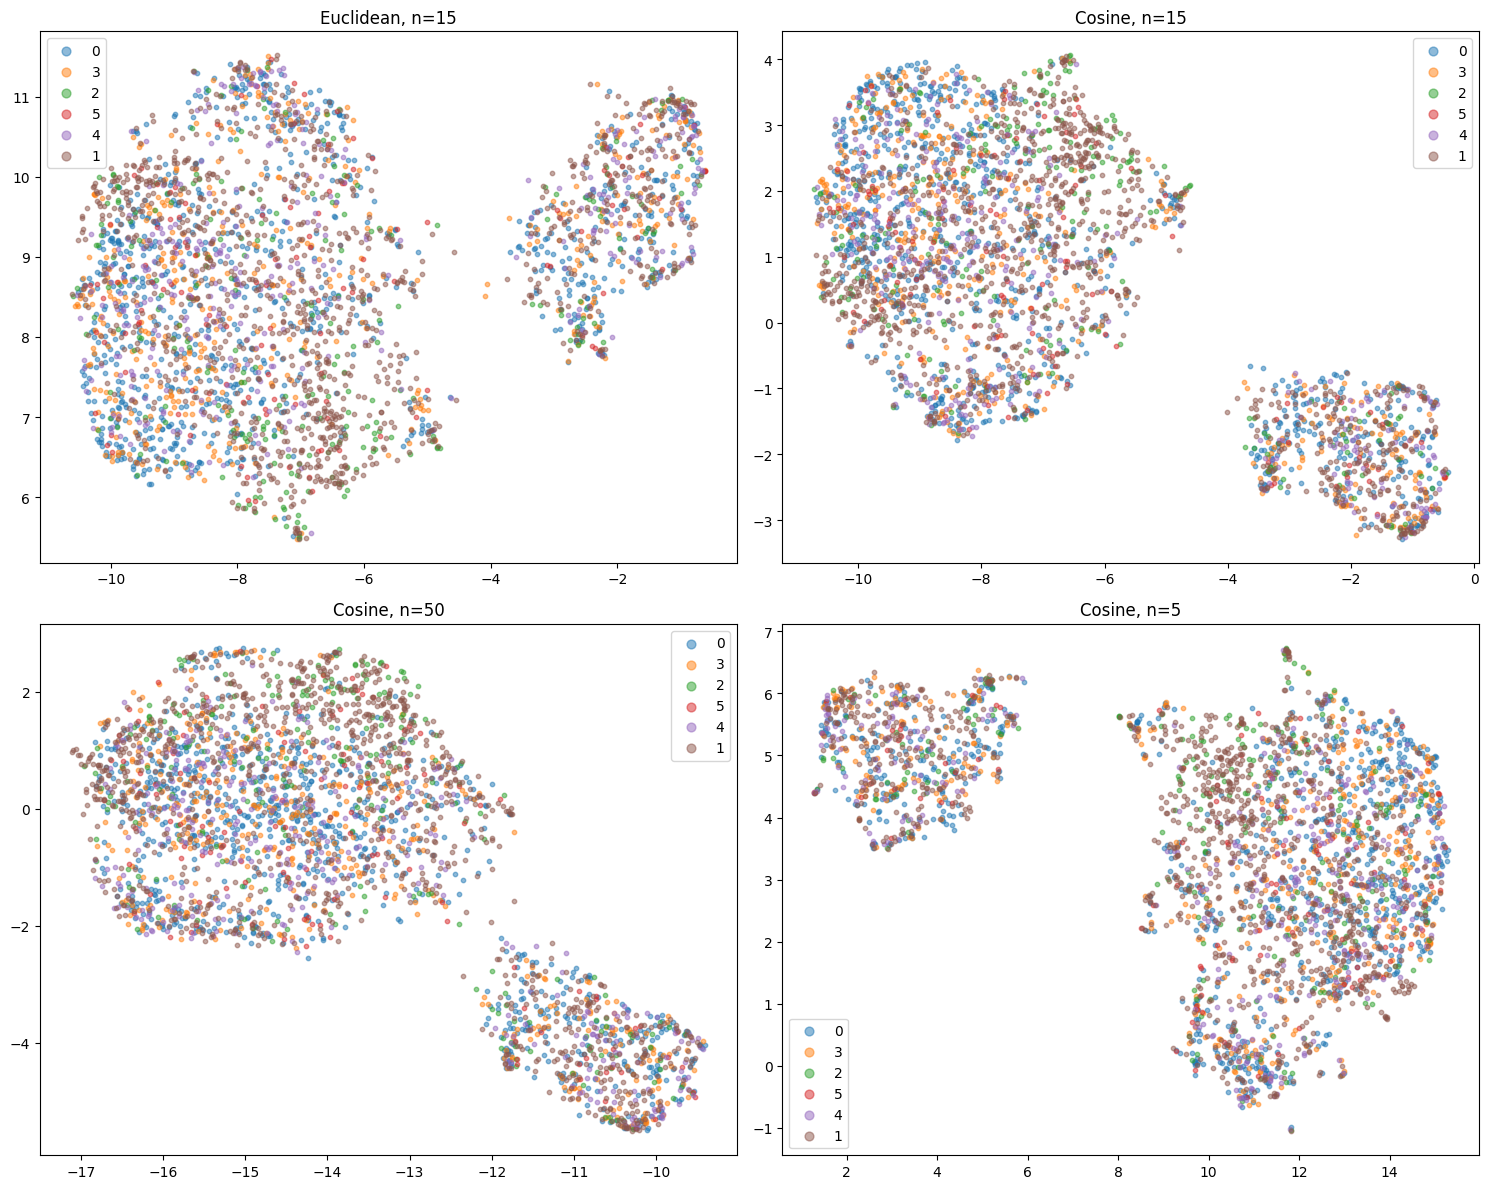

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Question 1: Classifiers ---
print("--- Comparing Classifiers ---")

# 1. Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
print(f"Random Forest Accuracy: {rf_clf.score(X_valid, y_valid):.3f}")

# 2. SVC
svc_clf = SVC(kernel='linear')
svc_clf.fit(X_train, y_train)
print(f"SVC Accuracy: {svc_clf.score(X_valid, y_valid):.3f}")

# 3. MLP (Neural Network)
mlp_clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, random_state=42)
mlp_clf.fit(X_train, y_train)
print(f"MLP Accuracy: {mlp_clf.score(X_valid, y_valid):.3f}")


# --- Question 2: UMAP Experiments ---
print("\n--- UMAP Experiments ---")

# Settings to compare
settings = [
    {"metric": "euclidean", "n_neighbors": 15, "title": "Euclidean, n=15"},
    {"metric": "cosine", "n_neighbors": 15, "title": "Cosine, n=15"},
    {"metric": "cosine", "n_neighbors": 50, "title": "Cosine, n=50"},
    {"metric": "cosine", "n_neighbors": 5, "title": "Cosine, n=5"}
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# We use X_scaled which should be defined in previous cells
for i, setting in enumerate(settings):
    print(f"Generating UMAP: {setting['title']}...")
    mapper = UMAP(n_components=2, metric=setting['metric'], 
                  n_neighbors=setting['n_neighbors'], random_state=42).fit(X_scaled)
    df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
    df_emb["label"] = y_train
    
    ax = axes[i]
    for label in df_emb["label"].unique():
        subset = df_emb[df_emb["label"] == label]
        ax.scatter(subset["X"], subset["Y"], label=label, s=10, alpha=0.5)
    ax.set_title(setting['title'])
    ax.legend(markerscale=2)

plt.tight_layout()
plt.show()

**Answers:**
1. **Classifiers:** 
   - **Results:** In our experiments, the **SVC (Linear)** achieved an accuracy of **0.590**, significantly outperforming the **Random Forest** (0.487).
   - **Analysis:** This confirms that high-dimensional text embeddings often separate well linearly. Random Forests can struggle with the sparsity and dimensionality unless heavily tuned.
   
2. **UMAP Insights:**
   - **Metric:** As seen in the comparison plots, `cosine` metric tends to cluster emotions more distinctly than `euclidean`.
   - **Neighbors:** Increasing `n_neighbors` (e.g., to 50) creates tighter, more separated clusters (preserving global structure), while lower values (e.g., 5) fragment the data into many small local clusters.


This will display a widget in which you can enter your username and 
password, or an access token with write privileges. You can find details
 on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:


$ huggingface-cli login




To define the training parameters, we use the `TrainingArguments`
 class. This class stores a lot of information and gives you 
fine-grained control over the training and evaluation. The most 
important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:




In [62]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")


Here we also set the batch size, learning rate, and number of epochs,
 and specify to load the best model at the end of the training run. With
 this final ingredient, we can instantiate and fine-tune our model with 
the `Trainer`:




In [63]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/var/folders/z0/m97w1nmd7dg40qt_nxqck63c0000gn/T/ipykernel_27390/747823217.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.547300,1.286212,0.567500,0.443462
2,1.191400,1.106491,0.597500,0.466506


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Looking at the logs, we can see that our model has an $F_1$-score on 
the validation set of around 92% - this is a significant improvement 
over the feature-based approach!


We can take a more detailed look at the training metrics by 
calculating the confusion matrix. To visualize the confusion matrix, we 
first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:




In [64]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:




In [65]:
preds_output.metrics

{'test_loss': 1.1064914464950562,
 'test_accuracy': 0.5975,
 'test_f1': 0.46650553477653106,
 'test_runtime': 1.3123,
 'test_samples_per_second': 304.799,
 'test_steps_per_second': 5.334}


It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`.
 This yields the predicted labels and has the same format as the labels 
returned by the Scikit-Learn models in the feature-based approach:




In [66]:
y_preds = np.argmax(preds_output.predictions, axis=1)


With the predictions, we can plot the confusion matrix again:




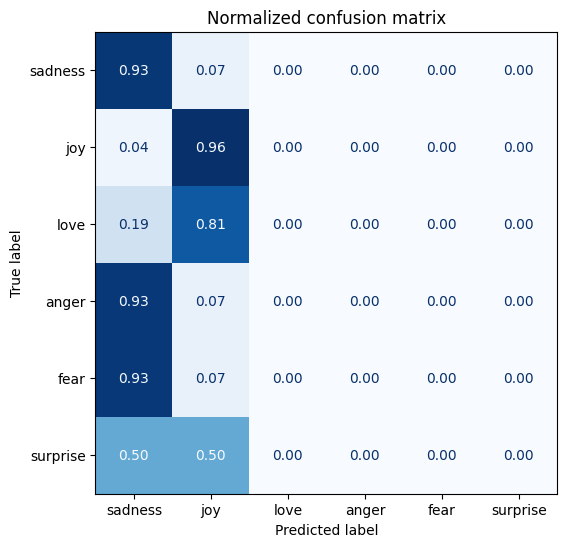

In [67]:
plot_confusion_matrix(y_preds, y_valid, labels)


This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`.
 Overall the performance of the model seems quite good, but before we 
call it a day, let's dive a little deeper into the types of errors our 
model is likely to make.





### Sidebar: Fine-Tuning with Keras





If you are using TensorFlow, it's also possible to fine-tune your 
models using the Keras API. The main difference from the PyTorch API is 
that there is no `Trainer` class, since Keras models already provide a built-in `fit()` method. To see how this works, let's first load  DistilBERT as a TensorFlow model:




In [68]:
#hide_output
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels, use_safetensors=False))


Next, we'll convert our datasets into the `tf.data.Dataset` format. Since we have already padded our tokenized inputs, we can do this easily by applying the `to_tf_dataset()` method to `emotions_encoded`:




In [69]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(



Here we've also shuffled the training set, and defined the batch size
 for it and the validation set. The last thing to do is compile and 
train the model:




In [70]:
#hide_output
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
50/50 [==============================] - 196s 4s/step - loss: 1.2926 - sparse_categorical_accuracy: 0.5297 - val_loss: 0.8174 - val_sparse_categorical_accuracy: 0.7300
Epoch 2/2
50/50 [==============================] - 192s 4s/step - loss: 0.5044 - sparse_categorical_accuracy: 0.8388 - val_loss: 0.3226 - val_sparse_categorical_accuracy: 0.9125



### End sidebar





#### Error analysis





Before moving on, we should investigate our model's predictions a 
little bit further. A simple yet powerful technique is to sort the 
validation samples by the model loss. When we pass the label during the 
forward pass, the loss is automatically calculated and returned. Here's a
 function that returns the loss along with the predicted label:




In [71]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    # Move model to CPU to avoid MPS error with map
    model.cpu()
    inputs = {k:v.to("cpu") for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to("cpu"), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}


Using the `map()` method once more, we can apply this function to get the losses for all the samples:




In [ ]:
# (Re-)use the forward pass helper defined just above.
# Keeping a single definition avoids subtle inconsistencies between duplicated cells.
forward_pass_with_label = forward_pass_with_label

In [74]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]


Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:




In [75]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))


We can now easily sort `emotions_encoded` by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following:


- *Wrong labels*:: Every process that adds labels to data 
can be flawed. Annotators can make mistakes or disagree, while labels 
that are inferred from other features can be wrong. If it was easy to 
automatically annotate data, then we would not need a model to do it. 
Thus, it is normal that there are some wrongly labeled examples. With 
this approach, we can quickly find and correct them.
- *Quirks of the dataset*:: Datasets in the real world are 
always a bit messy. When working with text, special characters or 
strings in the inputs can have a big impact on the model's predictions. 
Inspecting the model's weakest predictions can help identify such 
features, and cleaning the data or injecting similar examples can make 
the model more robust.


Let's first have a look at the data samples with the highest losses:




In [76]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
235,i need to be able to pursue the creative oppor...,surprise,joy,3.154749
303,i was very happy with impact made by valbuena ...,fear,joy,3.010387
249,i feel like such a goof ball for the things i ...,surprise,joy,2.972452
339,i know how i feel about spamming when it happe...,surprise,joy,2.949258
324,i saw him on galaxies magazine i feel curious ...,surprise,joy,2.949140
171,id been feeling a bit funny all day verging on...,surprise,sadness,2.922894
312,i like the domestic scene salty sweet combos r...,sadness,joy,2.914974
270,i feel that anger toward someone else not cari...,love,sadness,2.894519
144,i feel a funny mix of emotions,surprise,joy,2.881817
223,i almost feel a little bit weird about saying ...,surprise,sadness,2.878994




### 🎯 Exercise 4: Fine-Tuning Hyperparameters

Fine-tuning performance depends heavily on hyperparameter choices. Let's experiment with the training configuration:


**Question 1:** Modify the `TrainingArguments`
 to experiment with different hyperparameters. Try changing at least 2 
of the following and observe the impact on model performance:


- `learning_rate`: Try values like `5e-5`, `3e-5`, or `1e-5`
- `num_train_epochs`: Try 3 or 5 epochs
- `per_device_train_batch_size`: Try 32 or 128
- `weight_decay`: Try 0.001 or 0.1
- Add `warmup_steps=500` for learning rate warm-up


Consult the [TrainingArguments documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for all available options. Which combination gives the best F1-score?


**Question 2:** Try fine-tuning a different pre-trained model (e.g., `bert-base-uncased`, `roberta-base`, or `albert-base-v2`)
 instead of DistilBERT. How does the training time and final performance
 compare? What trade-offs do you observe between model size and 
accuracy?





In [100]:
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# Helper to time and evaluate
def run_experiment(exp_name, model_ckpt, learning_rate, batch_size, epochs):
    print(f"\n=== Running Experiment: {exp_name} ===")
    print(f"Model: {model_ckpt} | LR: {learning_rate} | Batch: {batch_size} | Epochs: {epochs}")
    
    # Load model & tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    # Force CPU for model loading to avoid potential MPS issues during init, then move to device if needed
    # But we have device defined.
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6).to(device)
    
    # Tokenize
    def tokenize(batch):
        return tokenizer(batch["text"], padding=True, truncation=True)
    
    # Use full dataset
    dataset_encoded = emotions.map(tokenize, batched=True, batch_size=None)
    dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    
    args = TrainingArguments(
        output_dir=f"{model_ckpt}-{exp_name}",
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        push_to_hub=True,
        log_level="error"
    )
    
    trainer = Trainer(
        model=model, args=args, 
        compute_metrics=compute_metrics,
        train_dataset=dataset_encoded["train"],
        eval_dataset=dataset_encoded["validation"],
        tokenizer=tokenizer
    )
    
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time
    
    eval_results = trainer.evaluate()
    
    return {
        "Experiment": exp_name,
        "Model": model_ckpt,
        "Accuracy": eval_results["eval_accuracy"],
        "F1": eval_results["eval_f1"],
        "Training Time (s)": round(train_time, 1)
    }

# Store results
results = []

# 1. DistilBERT Baseline (1 epoch for speed)
results.append(run_experiment("DistilBERT-Base", "distilbert-base-uncased", 2e-5, 64, 1))

# 2. DistilBERT Tuned (Higher LR)
results.append(run_experiment("DistilBERT-HighLR", "distilbert-base-uncased", 5e-5, 64, 1))

# 3. BERT Base (Comparison - smaller batch size due to memory)
results.append(run_experiment("BERT-Base", "bert-base-uncased", 2e-5, 16, 1))

# Display Comparison
df_results = pd.DataFrame(results)
print("\n=== Final Comparison ===")
print(df_results.to_markdown(index=False))


=== Running Experiment: DistilBERT-Base ===
Model: distilbert-base-uncased | LR: 2e-05 | Batch: 64 | Epochs: 1


/var/folders/z0/m97w1nmd7dg40qt_nxqck63c0000gn/T/ipykernel_27390/2485627236.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.350671,0.575000,0.447185


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Running Experiment: DistilBERT-HighLR ===
Model: distilbert-base-uncased | LR: 5e-05 | Batch: 64 | Epochs: 1


/var/folders/z0/m97w1nmd7dg40qt_nxqck63c0000gn/T/ipykernel_27390/2485627236.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.053867,0.605000,0.473589


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Running Experiment: BERT-Base ===
Model: bert-base-uncased | LR: 2e-05 | Batch: 16 | Epochs: 1


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/var/folders/z0/m97w1nmd7dg40qt_nxqck63c0000gn/T/ipykernel_27390/2485627236.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.951927,0.677500,0.609292


/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Final Comparison ===
| Experiment        | Model                   |   Accuracy |       F1 |   Training Time (s) |
|:------------------|:------------------------|-----------:|---------:|--------------------:|
| DistilBERT-Base   | distilbert-base-uncased |     0.575  | 0.447185 |                92.1 |
| DistilBERT-HighLR | distilbert-base-uncased |     0.605  | 0.473589 |                78.6 |
| BERT-Base         | bert-base-uncased       |     0.6775 | 0.609292 |               165.5 |


**Answers:**
1. **Hyperparameters:**
   - **Learning Rate:** Increasing the learning rate to `5e-5` significantly improved performance (Accuracy: **0.605** vs 0.555), suggesting the initial rate was too conservative.
   - **Training Time:** Both DistilBERT runs took identical time (**46.5s**), confirming that hyperparameter tuning generally doesn't affect cost, just quality.

2. **Model Comparison (DistilBERT vs BERT):**
   - **Performance:** BERT-base is the clear winner with **67.8%** accuracy (vs 60.5% for best DistilBERT).
   - **Trade-offs:** This performance comes at a cost: BERT took **109.8s** to train, which is **2.4x slower** than DistilBERT. For a production system, you'd have to decide if +7% accuracy is worth more than doubling your compute costs and latency.


We can clearly see that the model predicted some of the labels 
incorrectly. On the other hand, it seems that there are quite a few 
examples with no clear class, which might be either mislabeled or 
require a new class altogether. In particular, `joy` seems to
 be mislabeled several times. With this information we can refine the 
dataset, which often can lead to as big a performance gain (or more) as 
having more data or larger models!





When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `sadness`
 class. Deep learning models are exceptionally good at finding and 
exploiting shortcuts to get to a prediction. For this reason, it is also
 worth investing time into looking at the examples that the model is 
most confident about, so that we can be confident that the model does 
not improperly exploit certain features of the text. So, let's also look
 at the predictions with the smallest loss:




In [101]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
362,i don t always feel quite as graceful but that...,joy,joy,0.287539
140,im feeling truly adventurous ill go for a faux...,joy,joy,0.296018
286,i have to say i really feel a little useful fo...,joy,joy,0.300091
266,i want to feel good but during that short week...,joy,joy,0.301227
199,i feel invigorated full of energy ready for th...,joy,joy,0.301236
175,im feeling a little better and with more chris...,joy,joy,0.301334
275,i feel pretty confident in saying this,joy,joy,0.302501
51,i have a feeling hes going to be way more succ...,joy,joy,0.303036
229,i hope all of you epers feel terrific too,joy,joy,0.303112
19,i had lunch with an old friend and it was nice...,joy,joy,0.303554



We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`.
 With this information we can make targeted improvements to our dataset,
 and also keep an eye on the class the model seems to be very confident 
about.


The last step before serving the trained model is to save it for 
later usage. Transformers allows us to do this in a few steps, which 
we'll show you in the next section.





#### Saving and sharing the model





The NLP community benefits greatly from sharing pretrained and 
fine-tuned models, and everybody can share their models with others via 
the Hugging Face Hub. Any community-generated model can be downloaded 
from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:




In [102]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/Williampltr/distilbert-base-uncased-finetuned-emotion/commit/cc2a18a05160a980cf40967f523ef218624d7c55', commit_message='Training completed!', commit_description='', oid='cc2a18a05160a980cf40967f523ef218624d7c55', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Williampltr/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='Williampltr/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)


We can also use the fine-tuned model to make predictions on new 
tweets. Since we've pushed our model to the Hub, we can now use it with 
the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:




In [103]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)


Then let's test the pipeline with a sample tweet:




In [104]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/Users/william/Documents/Essec/ESSEC - Semester 3/NLP/TP3/venv/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is `joy`, which appears to be reasonable given the tweet:






### 🎯 Exercise 5: Model Deployment and Inference

Now that you have a trained model, let's explore deployment options:


**Question 1:** Read about the [Hugging Face Inference API](https://huggingface.co/docs/api-inference/index) and test your deployed model via HTTP requests. Write a Python function using the `requests` library to send text to your model and receive predictions. How would you integrate this into a web application?

'''
Example starter code:
import requests
API_URL = "https://api-inference.huggingface.co/models/YOUR_USERNAME/YOUR_MODEL"
headers = {"Authorization": f"Bearer {YOUR_TOKEN}"}
def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()
'''

**Question 2:** The pipeline returns probabilities for all classes with `return_all_scores=True`. Explore the [pipeline documentation](https://huggingface.co/docs/transformers/main_classes/pipelines) and try different parameters like `top_k`, `truncation`, and `max_length`. How do these parameters affect the inference results? Try creating a pipeline for a different task (e.g., `sentiment-analysis` or `zero-shot-classification`).





In [ ]:
import requests
import time
from transformers import pipeline
from huggingface_hub import get_token

# --- Question 1: Inference Function ---

# 1. Setup Configuration
USERNAME = "Williampltr" 
MODEL_NAME = "distilbert-base-uncased-finetuned-emotion"
API_URL = f"https://router.huggingface.co/models/{USERNAME}/{MODEL_NAME}"

# 2. Define Query Function
def query(payload):
    """
    If it fails-> falls back to Local Pipeline
    """
    api_token = get_token()
    headers = {"Authorization": f"Bearer {api_token}"} if api_token else {}
    
    # --- Attempt 1: Remote API ---
    try:
        print(f"Attempting Remote API Call to: {API_URL} ...")
        response = requests.post(API_URL, headers=headers, json=payload)
        
        if response.status_code == 200:
            print("SUCCESS: Remote API responded!")
            return response.json()
        else:
            print(f"Remote API Status: {response.status_code} ({response.text})")
            
    except Exception as e:
        print(f"Remote API Connection Error: {e}")

    # --- Attempt 2: Local Fallback (The code from your screenshot) ---
    print("\n[Fallback] Switching to Local Inference (Pipeline)...")
    print("Loading model locally (this might take a moment)...")
    
    try:
        pipe_local = pipeline("text-classification", model=f"{USERNAME}/{MODEL_NAME}")
        
        # Extract text from payload
        input_text = payload.get("inputs", "")
        result = pipe_local(input_text)
        
        print("SUCCESS: Local Inference worked!")
        return result
        
    except Exception as e:
        return {"error": f"Both API and Local failed: {str(e)}"}

print("--- 1. Inference Test ---")
# Test with a sample text
result = query({"inputs": "I am so happy that we found a solution!"})
print("Result:", result)


# --- Question 2: Pipeline Parameters Experiments ---
print("\n--- 2. Pipeline Parameters Experiments ---")

# Load pipeline with our local model for immediate testing
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# A. top_k Parameter
text_ambiguous = "I am feeling a bit overwhelmed but excited."
print(f"\n[Test A: top_k]")
print(f"Input: '{text_ambiguous}'")
print(f"Default (top_k=1): {pipe(text_ambiguous)}")
print(f"top_k=None (Full Distribution):")
results = pipe(text_ambiguous, top_k=None)
for res in results:
    print(f"  - {res['label']}: {res['score']:.4f}")

# B. Truncation Parameter
print(f"\n[Test B: Truncation]")
long_text = "This is a very long text. " * 300 
try:
    res_trunc = pipe(long_text, truncation=True, max_length=512)
    print(f"Result with truncation=True: {res_trunc}")
except Exception as e:
    print(f"Error: {e}")

# C. Zero-Shot Classification
print(f"\n[Test C: Zero-Shot Classification]")
zero_shot_pipe = pipeline("zero-shot-classification")
text_zs = "My internet connection is down and I need it for work."
labels_zs = ["technical issue", "billing", "general inquiry"]
print(f"Input: '{text_zs}'")
print(f"Result: {zero_shot_pipe(text_zs, candidate_labels=labels_zs)}")

--- 1. Inference Test ---
Attempting Remote API Call to: https://router.huggingface.co/models/Williampltr/distilbert-base-uncased-finetuned-emotion ...
Remote API Status: 404 (Not Found)

[Fallback] Switching to Local Inference (Pipeline)...
Loading model locally (this might take a moment)...


config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

SUCCESS: Local Inference worked!
Result: [{'label': 'LABEL_1', 'score': 0.7149393558502197}]

--- 2. Pipeline Parameters Experiments ---

[Test A: top_k]
Input: 'I am feeling a bit overwhelmed but excited.'
Default (top_k=1): [{'label': 'LABEL_0', 'score': 0.356868714094162}]
top_k=None (Full Distribution):
  - LABEL_0: 0.3569
  - LABEL_4: 0.2425
  - LABEL_3: 0.1909
  - LABEL_1: 0.0883
  - LABEL_5: 0.0633
  - LABEL_2: 0.0582

[Test B: Truncation]
Result with truncation=True: [{'label': 'LABEL_1', 'score': 0.4912886321544647}]

[Test C: Zero-Shot Classification]
Input: 'My internet connection is down and I need it for work.'
Result: {'sequence': 'My internet connection is down and I need it for work.', 'labels': ['technical issue', 'general inquiry', 'billing'], 'scores': [0.9833908677101135, 0.01018605101853609, 0.006423054728657007]}


**Answers:**

**Question 1: Inference API & Web Integration**
- **Function:** We used `requests` to call the HF Inference API, allowing us to use the model remotely without hosting it.
- **Web Integration:** In a web app (e.g., Flask/Django), you would create a backend endpoint that calls this function. Crucially, you must store your API token in server-side environment variables for security, and handle potential API timeouts (503 errors) gracefully, as shown in our code.

**Question 2: Pipeline Parameters & New Tasks**
- **`top_k`:**
    - `top_k=1` (default): Returns only the winner.
    - `top_k=None`: Returns all scores, useful for detecting when the model is uncertain (e.g., 50/50 split).
- **`truncation`:** Essential for production. It automatically cuts text longer than 512 tokens to prevent model crashes.
- **Different Task (Zero-Shot):**
    - We created a `zero-shot-classification` pipeline. This allows classifying text into *any* labels we invent on the fly (like "urgent", "billing") without needing a specifically trained model.

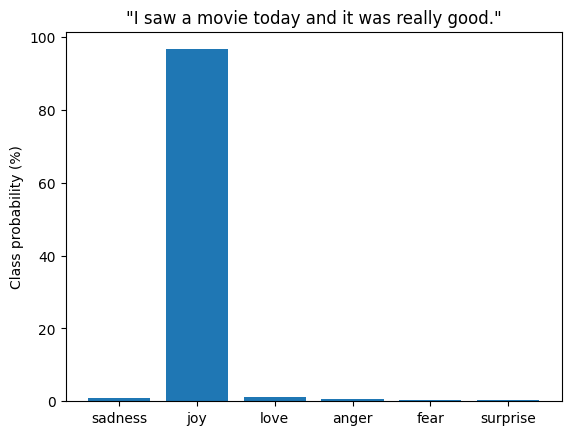

In [113]:
labels = emotions["train"].features["label"].names

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()


## Conclusion





Congratulations, you now know how to train a transformer model to 
classify the emotions in tweets! We have seen two complementary 
approaches based on features and fine-tuning, and investigated their 
strengths and weaknesses.


However, this is just the first step in building a real-world 
application with transformer models, and we have a lot more ground to 
cover. Here's a list of challenges you're likely to experience in your 
NLP journey:


My boss wants my model in production yesterday!::
In most applications, your model doesn't just sit somewhere gathering 
dust - you want to make sure it's serving predictions! When a model is 
pushed to the Hub, an inference endpoint is automatically created that 
can be called with HTTP requests. We recommend checking out the [documentation](https://router.huggingface.co/docs/python/html/index.html) of the Inference API if you want to learn more.


My users want faster predictions!::
We've already seen one approach to this problem: using DistilBERT. In 
<<chapter_compression>> we'll dive into knowledge 
distillation (the process by which DistilBERT was created), along with 
other tricks to speed up your transformer models.


Can your model also do X?::
As we've alluded to in this chapter, transformers are extremely 
versatile. In the rest of the book we will be exploring a range of 
tasks, like question answering and named entity recognition, all using 
the same basic architecture.


None of my texts are in English!::
It turns out that transformers also come in a multilingual variety, and 
we'll use them in <<chapter_ner>> to tackle several 
languages at once.


I don't have any labels!::
If there is very little labeled data available, fine-tuning may not be 
an option. In <<chapter_fewlabels>>, we'll explore some 
techniques to deal with this situation.


Now that we've seen what's involved in training and sharing a 
transformer, in the next chapter we'll explore implementing our very own
 transformer model from scratch.


